Import Libraries and Set Up Environment

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import shap
import warnings
import os
warnings.filterwarnings('ignore')

# Set styling for plots
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.grid(True)

sns.set_palette("viridis")


Define Data Loading and Preparation Function

In [5]:
def load_and_prepare_data(train_path, test_path):
    """Load and prepare the training and test datasets separately"""
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Apply interpolation to fill missing values
    train_data = train_data.interpolate(method='linear', axis=0)
    test_data = test_data.interpolate(method='linear', axis=0)

    # Define target
    target = "GlobalHorizontalIrradiance(GHI)(W/m²)"

    # Create feature matrices and target vectors
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    X_test = test_data.drop(target, axis=1)
    y_test = test_data[target]

    # Drop unnecessary features
    X_train = X_train.drop(['DirectNormalIrradiance(DNI)(W/m²)',
                            'DiffuseHorizontalIrradiance(DIF)(W/m²)', 'minute', 'month'],
                           axis=1, errors='ignore')
    X_test = X_test.drop(['DirectNormalIrradiance(DNI)(W/m²)',
                          'DiffuseHorizontalIrradiance(DIF)(W/m²)', 'minute', 'month'],
                         axis=1, errors='ignore')

    # Ensure consistent features between train and test
    common_features = list(set(X_train.columns) & set(X_test.columns))
    X_train = X_train[common_features]
    X_test = X_test[common_features]

    print("===== Data Quality Summary =====")
    print(f"Training dataset shape: {train_data.shape}")
    print(f"Test dataset shape: {test_data.shape}")

    print(f"\nTarget variable statistics (Train):")
    print(f"- Min: {y_train.min()}")
    print(f"- Max: {y_train.max()}")
    print(f"- Mean: {y_train.mean():.2f}")
    print(f"- Std Dev: {y_train.std():.2f}")

    print(f"\nTarget variable statistics (Test):")
    print(f"- Min: {y_test.min()}")
    print(f"- Max: {y_test.max()}")
    print(f"- Mean: {y_test.mean():.2f}")
    print(f"- Std Dev: {y_test.std():.2f}")

    return X_train, X_test, y_train, y_test


Define Model Training and Evaluation Function

In [6]:
def train_evaluate_model(X_train, X_test, y_train, y_test):
    """Train on training data and evaluate on test data"""
    # Feature scaling - fit on train, transform on both
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )

    print("\n===== Training XGBoost Model =====")

    # Hyperparameter tuning
    print("\n===== Hyperparameter Tuning =====")
    param_grid = {
        "max_depth": [9],
        "learning_rate": [0.05],
        "n_estimators": [100],
        "reg_lambda": [10],  # Test different L2 strengths
        "reg_alpha": [0.1]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Train model with best parameters
    best_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params
    )

    # No validation data to avoid data leakage
    best_model.fit(X_train_scaled, y_train)

    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n===== Model Performance on Test Set =====")
    print(f"RMSE: {rmse:.3f} ({(rmse/y_test.max())*100:.2f}% of max value)")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")

    # Cross-validation on training data only
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train,
                                cv=kf, scoring='neg_root_mean_squared_error')

    print(
        f"\nCross-Validation RMSE: {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Add after XGBoost evaluation
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    print(
        f"\nBaseline Linear Regression R²: {r2_score(y_test, y_pred_lr):.2f}")

    return best_model, X_train_scaled, X_test_scaled, y_pred


Define Model Analysis Function

In [ ]:
def analyze_model(model, X_train, X_test, y_train, y_test, y_pred, X_train_scaled, X_test_scaled):
    """Perform essential model analysis"""
    feature_names = X_train.columns

    # 1. Feature Importance Analysis
    plt.figure(figsize=(15, 10))

    # XGBoost feature importance
    plt.subplot(2, 2, 1)
    xgb.plot_importance(model, max_num_features=10, height=0.5, ax=plt.gca())
    plt.title("XGBoost Feature Importance")

    # SHAP Values for more accurate feature importance
    plt.subplot(2, 2, 2)
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_test_scaled, check_additivity=False)

        # Get feature importance from SHAP values
        feature_importance = np.abs(shap_values.values).mean(0)
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        top_features = feature_importance_df.head(10)
        plt.barh(np.arange(len(top_features)), top_features['Importance'])
        plt.yticks(np.arange(len(top_features)), top_features['Feature'])
        plt.title("SHAP Feature Importance")

        # Cumulative importance plot
        plt.subplot(2, 2, 3)
        sorted_idx = np.argsort(feature_importance)[::-1]
        sorted_importance = feature_importance[sorted_idx]
        cumulative_importance = np.cumsum(
            sorted_importance) / np.sum(sorted_importance)

        plt.plot(range(1, len(sorted_importance) + 1),
                 cumulative_importance, 'o-')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Importance')
        plt.axhline(y=0.99, color='g', linestyle='--', label='99% Importance')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Feature Importance')
        plt.legend()

        # Feature importance summary
        features_95 = np.argmax(cumulative_importance >= 0.95) + 1
        features_99 = np.argmax(cumulative_importance >= 0.99) + 1
    except Exception as e:
        print(f"SHAP analysis error: {e}")
        features_95 = 0
        features_99 = 0
        feature_importance_df = pd.DataFrame()

    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.text(0.1, 0.9, f"Top Features Summary:", fontweight='bold')
    plt.text(0.1, 0.8, f"{features_95} features explain 95% of variance")
    plt.text(0.1, 0.7, f"{features_99} features explain 99% of variance")

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Error Analysis
    plt.figure(figsize=(15, 10))

    errors = y_test - y_pred
    abs_errors = np.abs(errors)

    # Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, color='#3498db')
    min_val, max_val = min(y_test.min(), y_pred.min()), max(
        y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Actual GHI")
    plt.ylabel("Predicted GHI")

    # Error distribution
    plt.subplot(2, 2, 2)
    sns.histplot(errors, kde=True, bins=30, color='#2ecc71')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")

    # Residual plot
    plt.subplot(2, 2, 3)
    plt.scatter(y_pred, errors, alpha=0.5, color='#e74c3c')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")

    # Error statistics
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.text(0.1, 0.9, "Error Statistics:", fontweight='bold')
    plt.text(0.1, 0.8, f"Mean Error: {errors.mean():.3f}")
    plt.text(0.1, 0.7, f"Std Error: {errors.std():.3f}")
    plt.text(0.1, 0.6, f"Median Error: {np.median(errors):.3f}")
    plt.text(
        0.1, 0.5, f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    plt.text(0.1, 0.4, f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Add detailed regression proof analysis after error analysis
    plot_regression_proof(y_test, y_pred)

    # 3. Learning Curve Analysis - using training data only
    plt.figure(figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train,
        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training')
    plt.plot(train_sizes, test_mean, 'o-', color='#e74c3c', label='Validation')
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color='#3498db')
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color='#e74c3c')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed summary
    print("\n===== Detailed Analysis Summary =====")
    if not feature_importance_df.empty:
        print(f"Top 5 Features by Importance:")
        for i, (feature, importance) in enumerate(zip(
                feature_importance_df['Feature'].iloc[:5],
                feature_importance_df['Importance'].iloc[:5])):
            print(f"{i+1}. {feature}: {importance:.4f}")

        print(f"\n{features_95} features explain 95% of the variance")
        print(f"{features_99} features explain 99% of the variance")

    # Correlation of features with target
    corr_with_target = pd.DataFrame(X_train.corrwith(
        y_train).abs().sort_values(ascending=False))
    corr_with_target.columns = ['Correlation']
    print("\nTop 5 Features by Correlation with Target:")
    print(corr_with_target.head(5))

    # Sample predictions demonstration
    print("\n===== REGRESSION TASK DEMONSTRATION =====")
    sample_df = pd.DataFrame({
        'Actual Value': y_test.iloc[:5].values,
        'Predicted Value': y_pred[:5],
        'Difference': y_test.iloc[:5].values - y_pred[:5]
    })
    print(sample_df)

    print(f"\nRegression metrics:")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
    print(
        f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Define Regression Proof Function

In [9]:
def plot_regression_proof(y_test, y_pred, save_path='regression_proof.png'):
    """Generate comprehensive regression proof visualization"""
    from scipy import stats
    import statsmodels.api as sm
    from matplotlib.patches import Patch

    # Create figure
    plt.figure(figsize=(12, 10))

    # Main scatter plot with alpha for density visualization
    ax = plt.subplot(111)
    scatter = ax.scatter(y_test, y_pred, alpha=0.5,
                         edgecolor='k', linewidth=0.5)

    # Get axis limits and set equal aspect
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    margin = (max_val - min_val) * 0.05
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

    # Perfect prediction line (diagonal)
    ax.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin],
            'r--', linewidth=1.5, label='Perfect Prediction (y=x)')

    # Linear regression fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        y_test, y_pred)
    x_line = np.linspace(min_val - margin, max_val + margin, 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'b-', linewidth=2,
            label=f'Best Fit: y={slope:.3f}x+{intercept:.3f}')

    # Add prediction intervals (95%)
    try:
        # Convert to numpy for statsmodels
        X = sm.add_constant(y_test)
        model = sm.OLS(y_pred, X).fit()

        # Generate prediction intervals
        prstd, iv_l, iv_u = model.get_prediction(X).summary_frame(
            alpha=0.05)[['mean_se', 'obs_ci_lower', 'obs_ci_upper']].T.values

        # Plot prediction intervals
        ax.fill_between(y_test, iv_l, iv_u, color='gray', alpha=0.2,
                        label='95% Prediction Interval')
    except Exception as e:
        print(f"Could not calculate prediction intervals: {e}")

    # Add regression metrics to plot
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Create text box with metrics
    textstr = '\n'.join((
        f'$R^2 = {r2:.3f}$',
        f'RMSE = {rmse:.3f}',
        f'MAE = {mae:.3f}',
        f'Slope = {slope:.3f}',
        f'Intercept = {intercept:.3f}',
        f'p-value = {p_value:.3g}'
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Enhance plot appearance
    ax.set_xlabel('Actual GHI (W/m²)', fontsize=14)
    ax.set_ylabel('Predicted GHI (W/m²)', fontsize=14)
    ax.set_title('Regression Proof: Actual vs. Predicted Values', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')

    # Add a 2D histogram/heatmap to show density of points
    from scipy.stats import gaussian_kde

    # Define separate small subplot for density analysis
    ax2 = plt.axes([0.65, 0.22, 0.2, 0.2])  # [left, bottom, width, height]

    # Calculate point density
    xy = np.vstack([y_test, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort points by density
    idx = z.argsort()
    x_sorted, y_sorted, z_sorted = np.array(
        y_test)[idx], np.array(y_pred)[idx], z[idx]

    ax2.scatter(x_sorted, y_sorted, c=z_sorted,
                s=30, cmap='viridis')
    ax2.set_title('Point Density', fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


 Main Function

In [ ]:
def main():
    train_path = r"C:\Users\srikr\Desktop\Studies\Sem 4\Machine Learning\Project\Final\15_min_solar_data_preprocessed.csv"
    test_path = r"C:\Users\srikr\Desktop\Studies\Sem 4\Machine Learning\Project\Final\test_preprocessed.csv"

    if not os.path.exists(train_path):
        print(
            f"Error: File '{train_path}' not found. Please provide a valid training file.")
        return

    if not os.path.exists(test_path):
        print(
            f"Error: File '{test_path}' not found. Please provide a valid test file.")
        return

    # Load and prepare data
    X_train, X_test, y_train, y_test = load_and_prepare_data(
        train_path, test_path)

    # Train and evaluate model
    model, X_train_scaled, X_test_scaled, y_pred = train_evaluate_model(
        X_train, X_test, y_train, y_test)

    # Analyze model
    analyze_model(model, X_train, X_test, y_train, y_test,
                  y_pred, X_train_scaled, X_test_scaled)


Executing


===== Data Quality Summary =====
Training dataset shape: (651552, 18)
Test dataset shape: (43872, 18)

Target variable statistics (Train):
- Min: 0
- Max: 1048
- Mean: 227.51
- Std Dev: 313.45

Target variable statistics (Test):
- Min: 0
- Max: 1046
- Mean: 229.64
- Std Dev: 317.50

===== Training XGBoost Model =====

===== Hyperparameter Tuning =====
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 10}

===== Model Performance on Test Set =====
RMSE: 75.429 (7.21% of max value)
MAE: 38.608
R² Score: 0.944

Cross-Validation RMSE: 75.572 ± 0.440

Baseline Linear Regression R²: 0.34


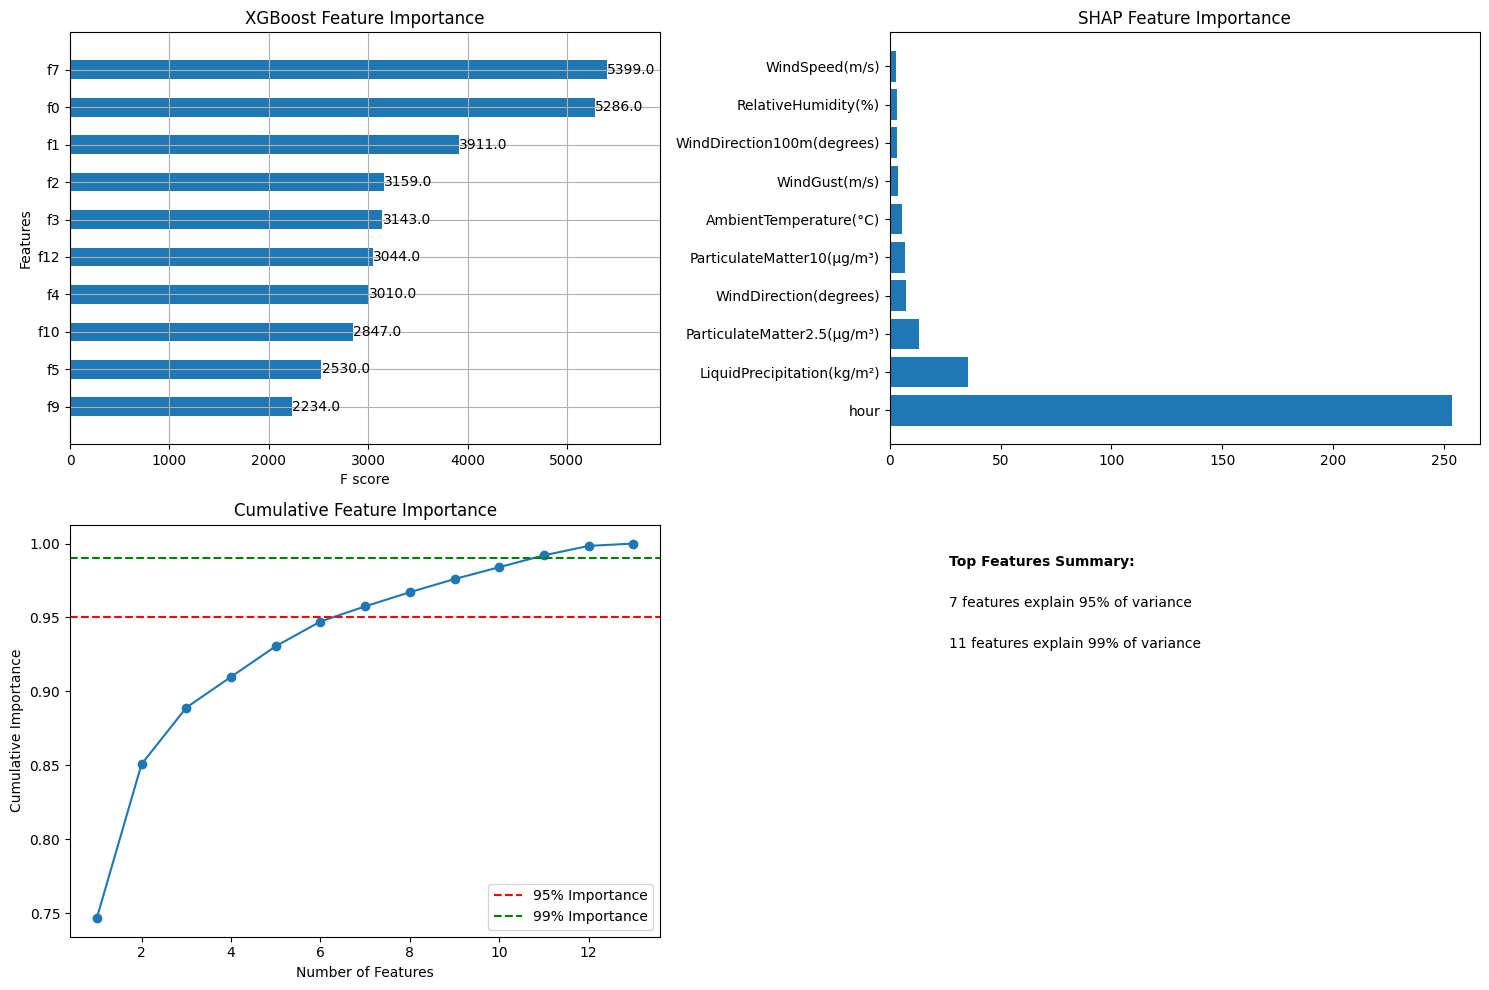

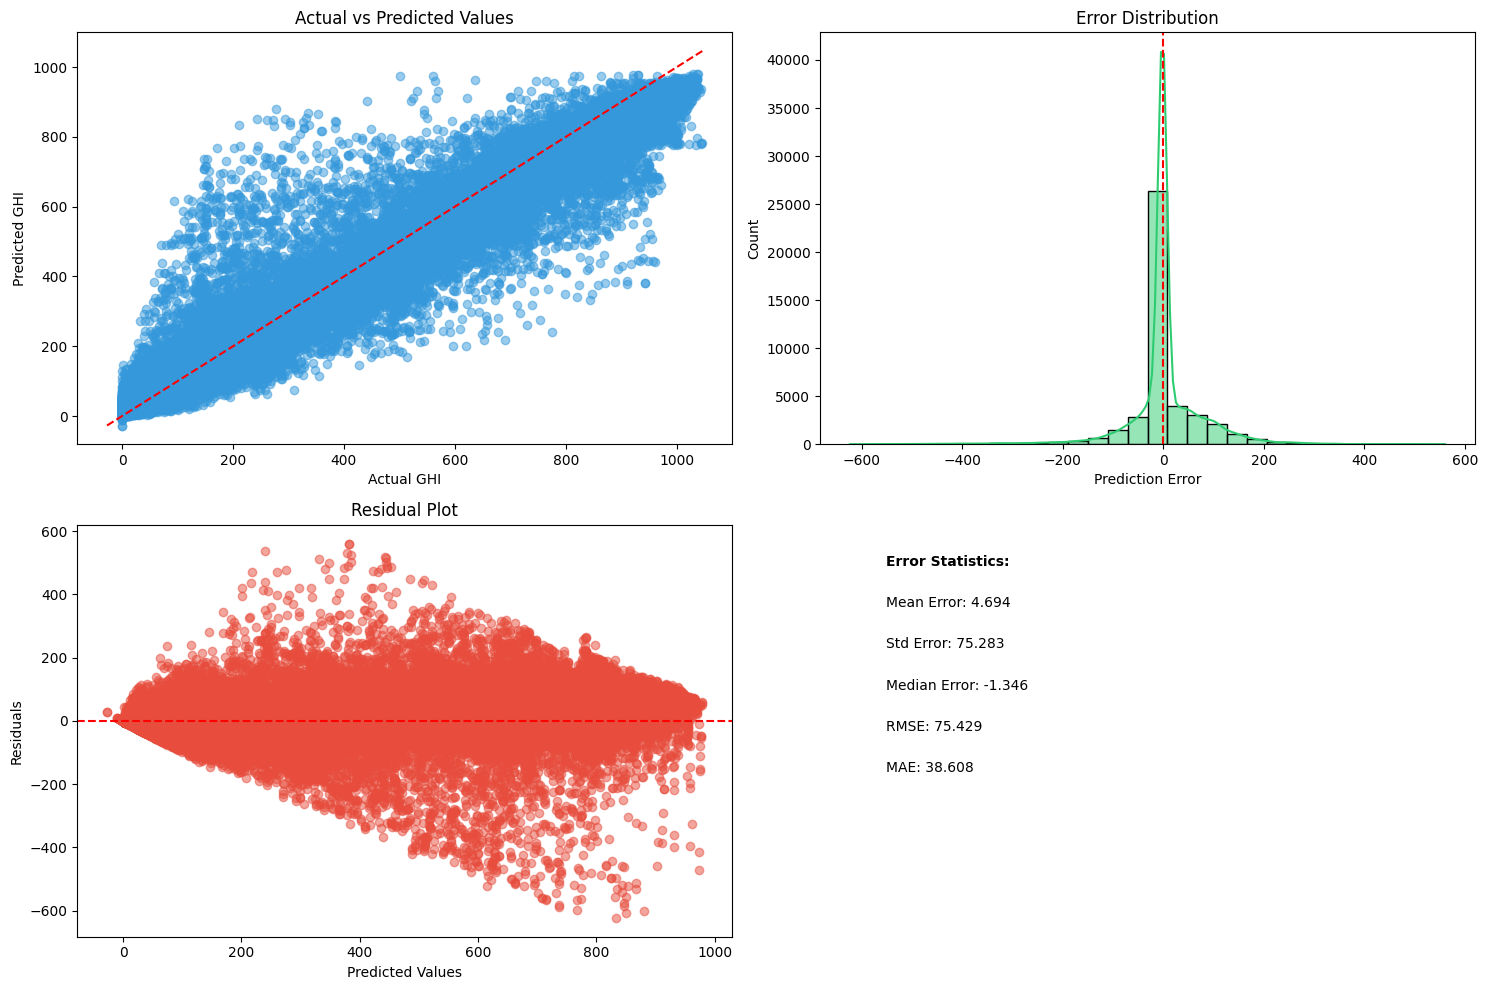

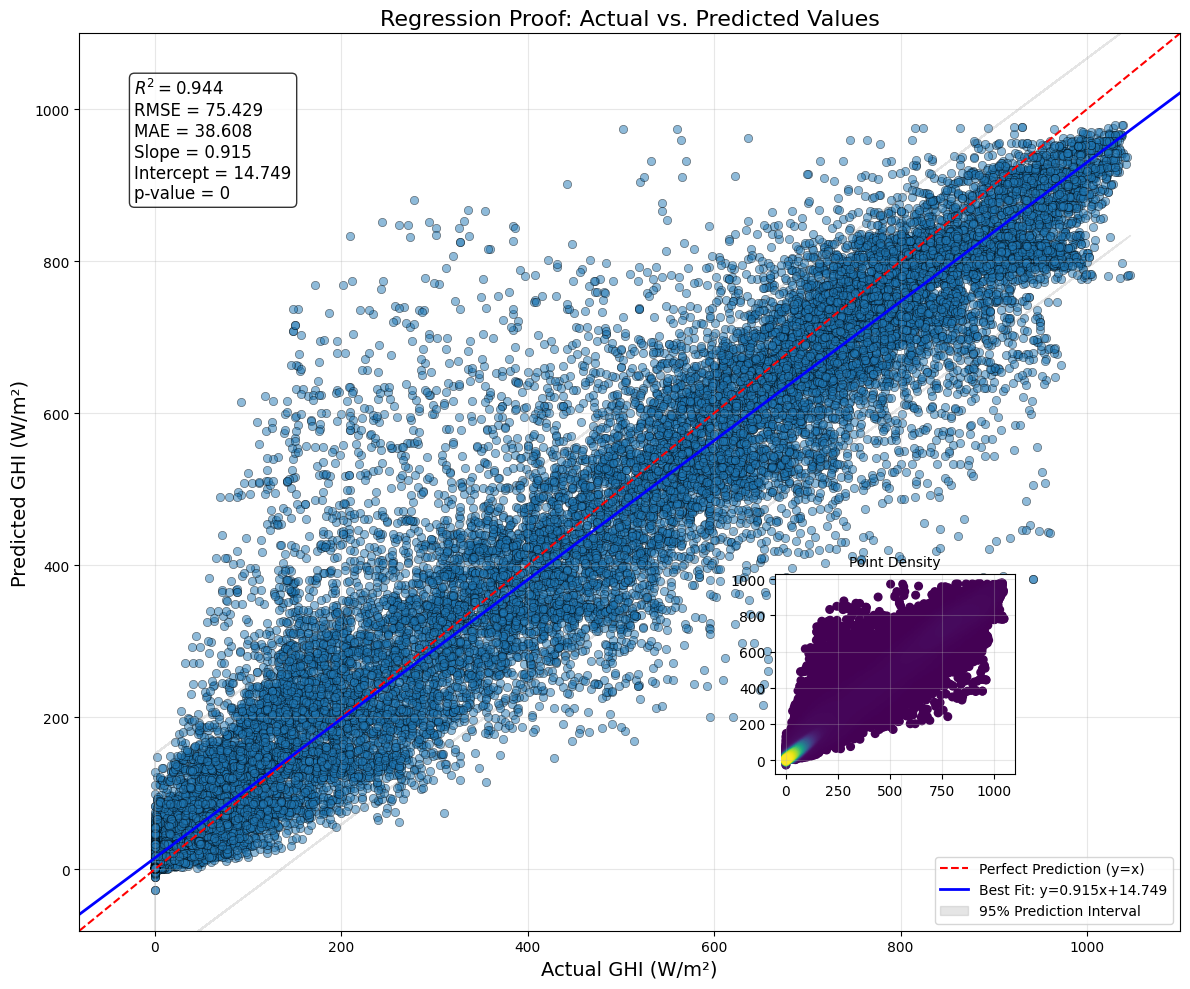

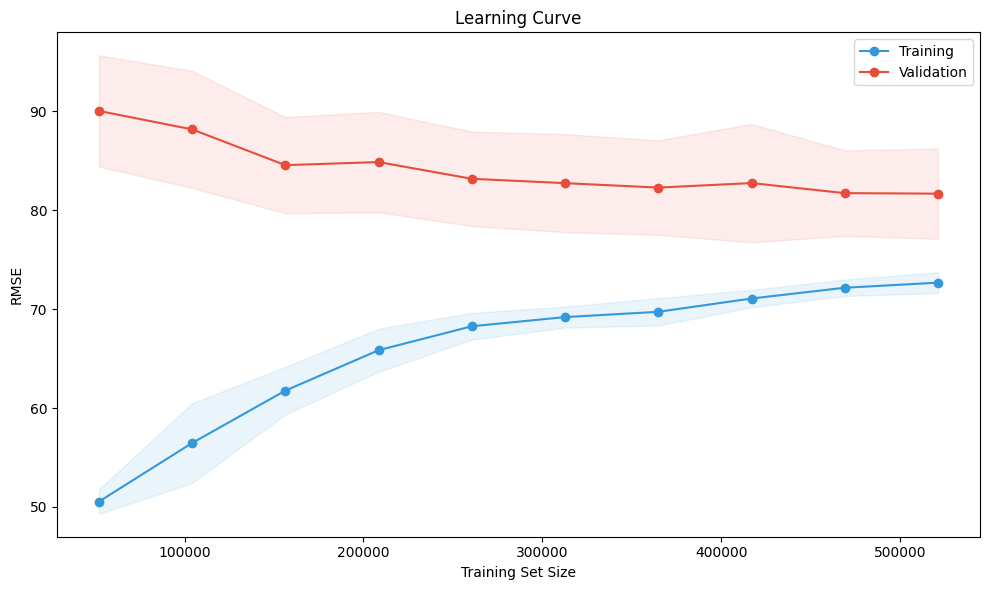


===== Detailed Analysis Summary =====
Top 5 Features by Importance:
1. hour: 253.6985
2. LiquidPrecipitation(kg/m²): 35.3793
3. ParticulateMatter2.5(µg/m³): 12.9814
4. WindDirection(degrees): 7.0776
5. ParticulateMatter10(µg/m³): 7.0268

7 features explain 95% of the variance
11 features explain 99% of the variance

Top 5 Features by Correlation with Target:
                             Correlation
hour                            0.483624
RelativeHumidity(%)             0.261764
AmbientTemperature(°C)          0.192012
ParticulateMatter2.5(µg/m³)     0.170355
WindSpeed100m(m/s)              0.165498

===== REGRESSION TASK DEMONSTRATION =====
   Actual Value  Predicted Value  Difference
0             0         1.345665   -1.345665
1             0         1.345665   -1.345665
2             0         1.345665   -1.345665
3             0         1.345665   -1.345665
4             0         1.345665   -1.345665

Regression metrics:
Mean Squared Error: 5689.50
Root Mean Squared Error: 75.43

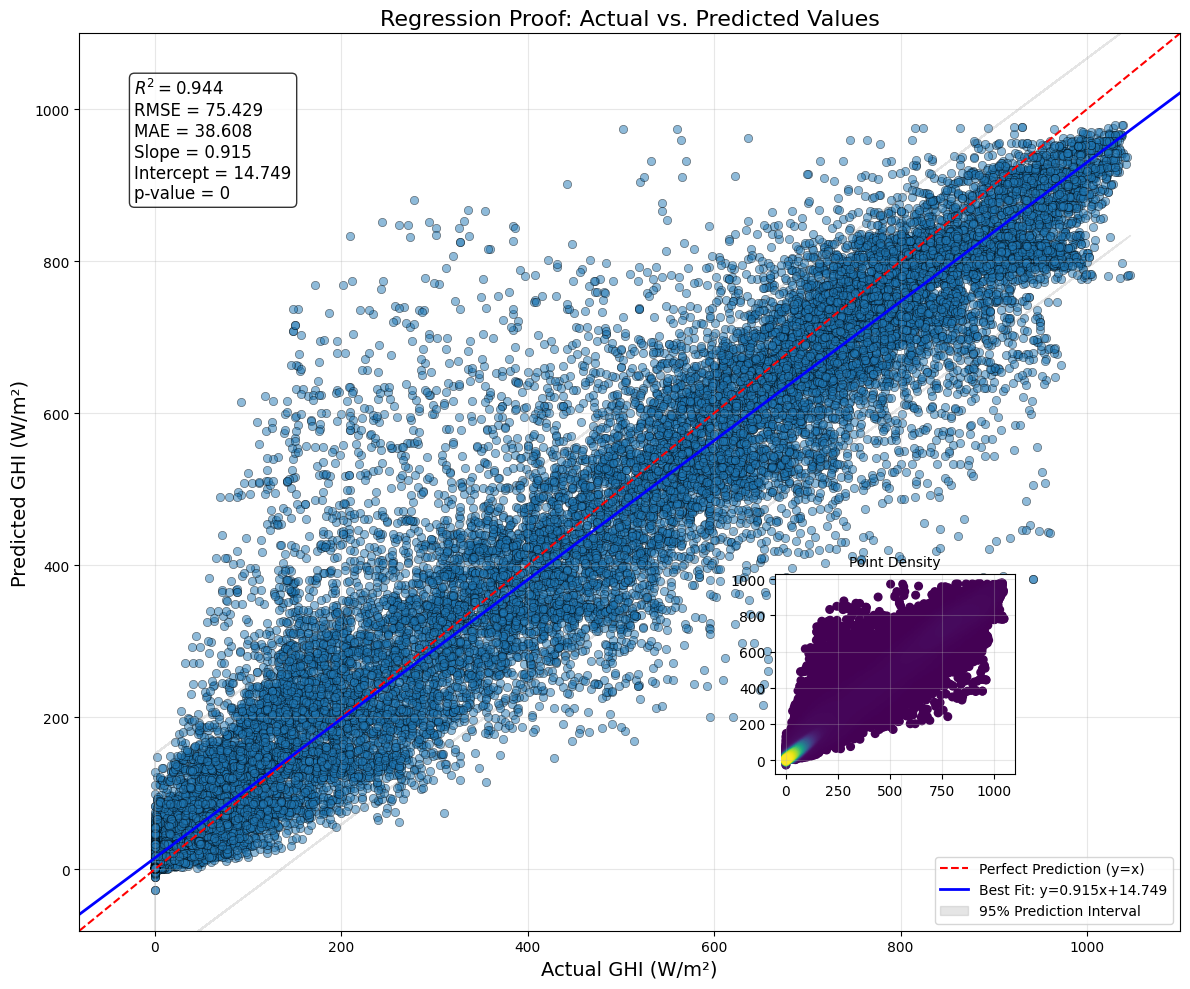

In [11]:
if __name__ == "__main__":
    main()
